# PyQNI demonstration notebook - Ethylene Carbonate

This notebook demonstrates how to use PyQNI for computing cross sections of H in battery elecrolytes.

## Imports

First, we import the PyQNI framework. If the notebook is placed in te different location, the PyQNI framework path has to be updated.

In [1]:
import sys
sys.path.append(r'..\..\framework') # update path if necessary
from PyQNI import *

We will also use the *matplotlib* package to display charts and the *numpy* package to work with arrays.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##  Single molecule (EC)

We choose the energy range from 1 meV to 1 eV

In [3]:
e_vals = np.geomspace(1e-3,1,401) 

We create a compound corresponding to Ethylene Carbonate ($C_3H_4O_3$, with a density of 1.32 g/cm$^3$)

In [4]:
ec = compound(composition={'C':3.0, 'H':4.0, 'O':3}, spec_weight=1.32)

We can obtain the total cross section (per molecule) like this:

In [5]:
e, xs_ec_tot = ec.cross_sections(e_vals=e_vals)

To get the cross section contribution from given elements only, use the 'partial' parameter. Here, to get everything except hydrogen:

In [6]:
_, xs_ec_woH = ec.cross_sections(e_vals=e_vals, partial='C,O')

Or to get the contributions from carbon or oxygen only:

In [7]:
_, xs_ec_onlyC = ec.cross_sections(e_vals=e_vals, partial='C')
_, xs_ec_onlyO = ec.cross_sections(e_vals=e_vals, partial='O')

We can compute the hydrogen contribution by subtracting the cross section without hydrogen from the total cross section (in a real case, the total cross section would be the experimentally measured one):

In [8]:
xs_ec_fromH = xs_ec_tot - xs_ec_woH

And the cross section for a single hydrogen atom by dividing by the number of atoms:

In [9]:
xs_ec_1xH = xs_ec_fromH/4

In [10]:
plt.loglog(e, xs_ec_tot)
plt.loglog(e, xs_ec_woH)
plt.loglog(e, xs_ec_onlyC)
plt.loglog(e, xs_ec_onlyO)
plt.loglog(e, xs_ec_fromH)
plt.loglog(e, xs_ec_1xH)
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Cross section [barn]')
plt.legend(['Total','Without H','only C','only O', 'from H', '1x H atom'])
plt.show()

## Mixture (EC:DMC)

And now, a mixture of two compunds ... First, we define Dimethyl Carbonate ($C_3H_6O_3$ with a density of 1.07cm$^3$):

In [11]:
dmc = compound(composition={'C':3.0, 'H':6.0, 'O':3}, spec_weight=1.07)

And then EC:DMC as a mixture with 1:1 volume fractions: 

In [12]:
ec_dmc = mixture([(ec,1), (dmc,1)], frac_type='vol')

__Important__: if no specific weight is give for the mixture, it is assumed that the volume of its components just add up (which is not necessarily the case !). To be more precise, it is better to know the specific weight of the mixture and to give it as a parameter.

For mixture, we cannot get a cross section, because the molecular density is not defined (it is different for the two components). What we can get is the attenuation coefficient. Here the total one:

In [13]:
e, ac_ec_dmc_tot = ec_dmc.att_coeff(e_vals=e_vals)

And the one excluding hydrogen (aka only from C and O):

In [14]:
e, ac_ec_dmc_woH = ec_dmc.att_coeff(e_vals=e_vals, partial='C,O')

We can subtract bot to get the attenuation coefficient contribution of hydrogen (again, in a real case, the total attenuation coefficient would be the experimentally measured one):

In [15]:
ac_ec_dmc_fromH = ac_ec_dmc_tot - ac_ec_dmc_woH

In [16]:
plt.loglog(e, ac_ec_dmc_tot)
plt.loglog(e, ac_ec_dmc_woH)
plt.loglog(e, ac_ec_dmc_fromH)
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Att. Coeff [cm^-1]')
plt.legend(['Total','Without H','from H'])
plt.plot()

[]

To get the hydrogen cross section, we need to know the atomic density of H in the mixture. Currently, this is not provided by PyQNI but this could be improved ...

## Electrolyte (1M LiPF6 in EC:DMC)

Now we can mix $LiPF_6$ with EC:DMC. Unfortunately, there is no "mole per liter" mixture mode yet in PyQNI (but this will probably be added very soon), so the mass fraction has to be calculated "manually".

First, we create the LiPF6 compound:

In [17]:
lipf6 = compound({'Li':1, 'P':1, 'F':6}, spec_weight=1.5)

Then we compute the mass fraction of LiPF6 for a concentration of 1M based on the solvent density and the salt molecular weight:

In [18]:
ec_dmc_sw = ec_dmc.spec_weight()
print('EC:DMC specific weight: ', ec_dmc_sw, 'g/cm^3')

EC:DMC specific weight:  1.195 g/cm^3


In [19]:
mass_1M_lipf6 = lipf6.molar_mass()
print('Mass of 1M of LiPF6: ', mass_1M_lipf6, 'g')

Mass of 1M of LiPF6:  151.925 g


In [20]:
mass_1L_ec_dmc = ec_dmc_sw*1000
print('Mass of 1L of EC:DMC: ', mass_1L_ec_dmc, 'g')

Mass of 1L of EC:DMC:  1195.0 g


In [21]:
mf_lipf6 = mass_1M_lipf6/(mass_1L_ec_dmc + mass_1M_lipf6)
print('Mass fraction of LiPF6: ', mf_lipf6)

Mass fraction of LiPF6:  0.11279395660485923


Now, we can do the mixture. The mass fraction of EC:DMC, if not specified, is assumed to be the complement to 1.

**Important again**: If we do not give the specific weight of the mixture, it we be assumed that the volumes of all compnents add up (probably not a very good approximation when dissolvind a salt)

In [22]:
lipf6_ec_dmc = mixture([(lipf6, mf_lipf6), ec_dmc], frac_type='mass')

And we can do the same kind of calculations than previously (also extracting the Li contribution here):

In [23]:
e, ac_lipf6_ec_dmc_tot = lipf6_ec_dmc.att_coeff(e_vals=e_vals)

In [24]:
e, ac_lipf6_ec_dmc_woH = lipf6_ec_dmc.att_coeff(e_vals=e_vals, partial='C,O,Li,P,F')

In [25]:
e, ac_lipf6_ec_dmc_onlyLi = lipf6_ec_dmc.att_coeff(e_vals=e_vals, partial='Li')

In [26]:
ac_lipf6_ec_dmc_fromH = ac_lipf6_ec_dmc_tot - ac_lipf6_ec_dmc_woH

[]

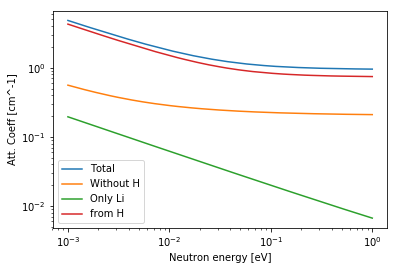

In [27]:
plt.loglog(e, ac_lipf6_ec_dmc_tot)
plt.loglog(e, ac_lipf6_ec_dmc_woH)
plt.loglog(e, ac_lipf6_ec_dmc_onlyLi)
plt.loglog(e, ac_lipf6_ec_dmc_fromH)
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Att. Coeff [cm^-1]')
plt.legend(['Total','Without H','Only Li','from H'])
plt.plot()